## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from ipywidgets import interact, interactive

In [2]:
from epistasis.plotting import epistasis
from epistasis.stats import pearson
from epistasis.simulate.linear import AdditiveSimulation
from epistasis.simulate.nonlinear import NonlinearSimulation
from epistasis.models.linear import LinearEpistasisModel

In [3]:
=from epistasis.models import (LinearEpistasisRegression, NonlinearEpistasisModel)

In [4]:
def power_transform(x, lmbda, A, B):
    #B = min(model.phenotypes)
    gmean = sp.stats.mstats.gmean(x + A)
    if lmbda == 0:
        return gmean*np.log(x+A)
    else:
        first = (x+A)**lmbda
        out = (first - 1.0)/(lmbda * gmean**(lmbda-1)) + B
        return out
    
def reverse_function(y, lmbda, A, B):
    gmean = sp.stats.mstats.gmean(model.statistics.linear()+A)
    return (gmean**(lmbda-1)*lmbda*(y - B) + 1)**(1/lmbda) - A

def function(x, k):
    return ((k+1)*x) / (k*x + 1) 

## Initialize a genotype-phenotype map with epistasis.

In [16]:
initial = AdditiveSimulation.quick_start(5,5, model_type="global", coeff_range=(-.01,.01))
initial.epistasis.values[0] = .5
initial.epistasis.values[1:6] = np.random.rand(5) * .15
values = initial.epistasis.values

In [17]:
initial.phenotypes

array([-0.00197159, -0.01315913,  0.01600079, -0.00496913, -0.02667523,
        0.00969362, -0.0361692 ,  0.03852374, -0.01495685,  0.00446672,
        0.01249976,  0.02725499, -0.00322386, -0.01386263, -0.03294185,
       -0.0072532 ,  0.03866919, -0.07138728, -0.00416835,  0.00472984,
        0.02432407,  0.04189471, -0.01205298,  0.01517676, -0.05601079,
       -0.01631625, -0.00620789, -0.02063105, -0.05374027, -0.00608935,
        0.03650717,  0.0387079 ])

In [209]:
print(np.mean(abs(initial.epistasis.values[1:6])))
print(np.mean(abs(values[6:])))
print(np.mean(abs(values[6:])) / np.mean(abs(initial.epistasis.values[1:6])))

0.0746346464957
0.00482336988968
0.0646264183747


In [9]:
values = np.array([  5.00000000e-01,   3.34951489e-03,   1.28477614e-01,
         6.61096956e-02,   1.31881709e-01,   4.33546996e-02,
         5.30164499e-03,   5.64883892e-04,  -3.79155229e-04,
        -7.29823966e-03,  -6.95384520e-03,   6.20585012e-03,
         5.19262442e-03,  -5.85750554e-03,   6.05720340e-03,
        -7.09030059e-03,   4.52295895e-03,   1.66726657e-03,
         4.24449352e-03,  -6.34035176e-03,  -4.60532326e-03,
        -4.23098101e-03,   3.38367575e-03,   6.95966457e-03,
        -4.60099122e-03,   4.35709384e-05,  -9.14285188e-03,
         8.16217118e-03,  -1.35571003e-03,   5.09411701e-03,
        -7.08329281e-03,   3.06894361e-03])

0.0976557169072 0.864234274553


(<epistasis.simulate.additive.AdditiveSimulation at 0x10b31d978>,
 2.0,
 2.0)

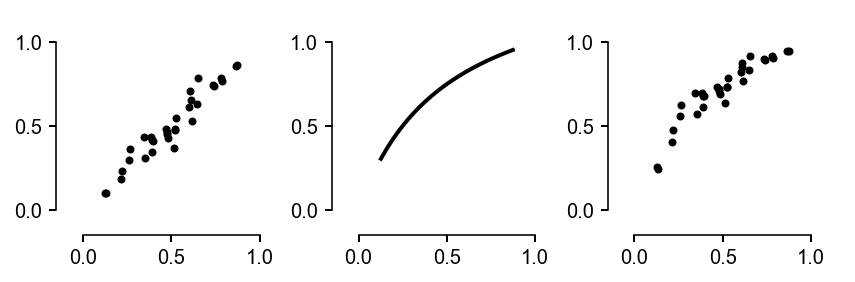

In [13]:
def fig3(
    magnitude_of_epistasis="3.0",
    shape="1.0",
    order=5,
    show_epistasis=False, 
    save=False):
    
    #sys.tracebacklimit=0
    magnitude_of_epistasis = float(magnitude_of_epistasis)
    shape = float(shape)
    
    # Construct the linear space
    linear = AdditiveSimulation.quick_start(5, order, model_type="global", coeff_range=(-1,1))
    linear.epistasis.values = np.array(values[:linear.epistasis.n])
    linear.epistasis.values[6:] = linear.epistasis.values[6:] * magnitude_of_epistasis 
    linear.build()
    
    # Show the epistasis plot
    if show_epistasis:
        labels = linear.epistasis.labels
        vals = linear.epistasis.values
        fig, ax = epistasis(vals, labels, figsize=(2.25,2), y_axis_name="", xgrid=False, ybounds=(-.15,.15))
        if save:
            fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/epistasis" +
                       str(magnitude_of_epistasis) + ".svg", format="svg")
    
    fig, ax = plt.subplots(1,3, figsize=(7,2))
    ax[0].plot(linear.p_additive, linear.phenotypes,'k.')
    ax[0].axis([-0.15,1.15,-0.15,1.15])
    ax[0].spines['bottom'].set_bounds(0,1.)
    ax[0].spines['left'].set_bounds(0,1.)
    ax[0].set_xticks([0,.5,1])
    
    # Initialize the nonlinear simulation
    nonlinear = NonlinearSimulation.from_linear(linear, function=function, p0=(shape,))

    # Initialize figure
    x = np.linspace(min(linear.p_additive), max(linear.p_additive),100)
    ax[1].plot(x, nonlinear.function(x, shape), '-k')
    ax[1].axis([-0.15,1.15,-0.15,1.15])
    ax[1].spines['bottom'].set_bounds(0,1.)
    ax[1].spines['left'].set_bounds(0,1.) 
    ax[1].set_xticks([0,.5,1])

    
    ax[2].plot(linear.p_additive, nonlinear.phenotypes, 'k.')
    ax[2].axis([-0.15,1.15,-0.15,1.15])
    ax[2].spines['bottom'].set_bounds(0,1.)
    ax[2].spines['left'].set_bounds(0,1.) 
    ax[2].set_xticks([0,.5,1])

    # Construct the model and fit
    model = NonlinearEpistasisModel.from_gpm(nonlinear, 
        function=power_transform, 
        order=1, 
        model_type="global",
        fix_linear=True,
    )
    if save:
        fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/nonlinear" +
                    str(magnitude_of_epistasis) + "-" + str(shape) + ".svg", format="svg")
    print(min(linear.phenotypes), max(linear.phenotypes))
    return linear, nonlinear, model, magnitude_of_epistasis, shape

q = interactive(fig3, order=(1,6,1))
q

R-squared of fit: 0.943648898051
lmbda: 0.452789729071
B: 1.14920195869
A: -0.393971841975


/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:313: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


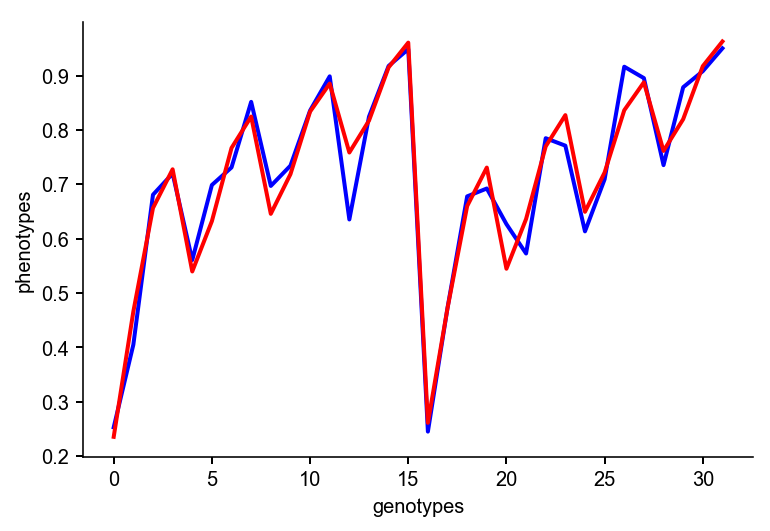

In [40]:
linear = q.result[0]
nonlinear = q.result[1]
model = q.result[2]
magnitude_of_epistasis = q.result[3]
shape = q.result[4]
model.fit_widget(
    lmbda=(-5,5,.1),
    A=(-10,10,1),
    B=(-10,10,1),
)

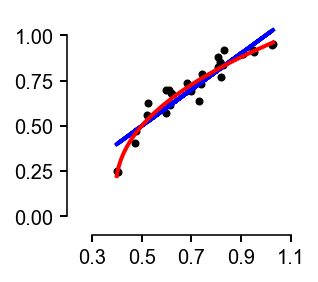

In [63]:
fig, ax = plt.subplots(figsize=(2,2))

model_add = LinearEpistasisRegression.from_gpm(nonlinear, order=1, model_type="global")
model_add.fit()

padd = model_add.statistics.predict()
pobs = nonlinear.phenotypes
ax.plot(padd, pobs, 'k.')

linear_x = padd
linear_y = padd

nonlinear_x = np.linspace(min(linear_x), max(linear_x), 1000)
nonlinear_y = model.function(nonlinear_x, *model.parameters.get_params())
#model_y2 = power_transform(model_x, *model.parameters.get_params())
ax.plot(linear_x, linear_y, 'b-')
ax.plot(nonlinear_x, nonlinear_y, 'r-')

#ax.plot(model_x, model_y2, 'b.')

#ax.axis("equal")
ax.axis([.2,1.1,-0.1,1.1])
ax.spines['bottom'].set_bounds(.3,1.1)
ax.spines['left'].set_bounds(0,1.) 
#ax.set_xticks([0,.5,1])

ax.set_xticks([.3,.5,.7,.9, 1.1])
#ax.set_yticks([0,.5,1])
#ax.set_xticklabels([0, ,1])
#ax.set_yticklabels([0, '',1])

fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/model-linear-fit.svg", format="svg")

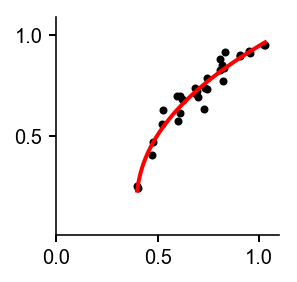

In [61]:
fig, ax = plt.subplots(figsize=(2,2))

padd = model.statistics.linear()
pobs = model.phenotypes
ax.plot(padd, pobs, 'k.')

model_x = np.linspace(min(padd), max(padd), 100) 
model_y = model.function(model_x, *model.parameters.get_params())
ax.plot(model_x, model_y, 'r-')

ax.axis("equal")
ax.axis([0,1.1,0,1.1])
ax.set_xticks([0,.5,1])
ax.set_yticks([0,.5,1])
#ax.set_xticklabels([0, ,1])
#ax.set_yticklabels([0, '',1])

fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/model-nonlinear-fit.svg", format="svg")

# Output to svg

0.126826767521 0.873173232479
0.126826767521 0.873173232479


/Users/Zsailer/virtual/py3/lib/python3.5/site-packages/scipy/stats/stats.py:533: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
/Users/Zsailer/virtual/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


0.126826767521 0.873173232479
0.0976557175228 0.864234273934
0.0976557175228 0.864234273934
0.0976557175228 0.864234273934
0.0617856377523 0.916063647843
0.0617856377523 0.916063647843
0.0617856377523 0.916063647843


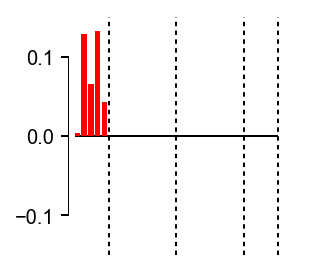

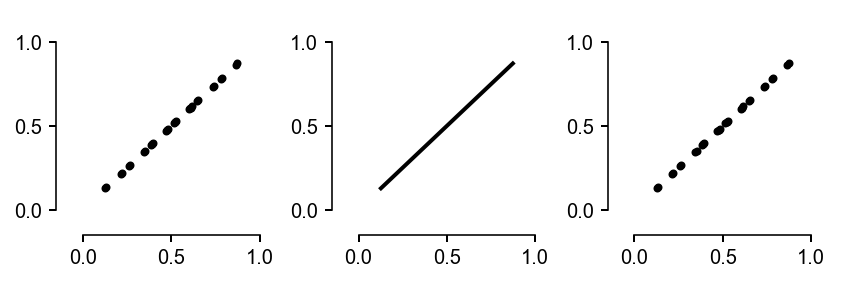

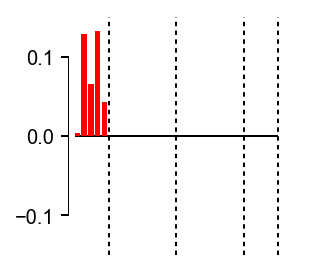

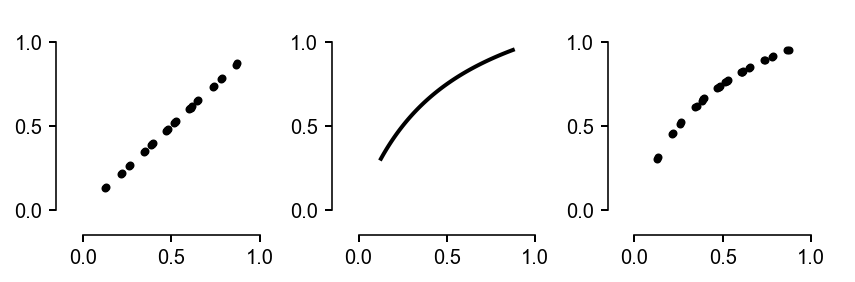

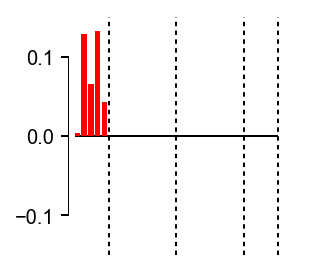

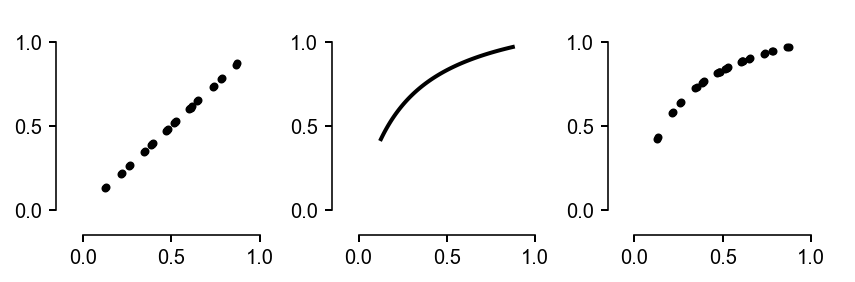

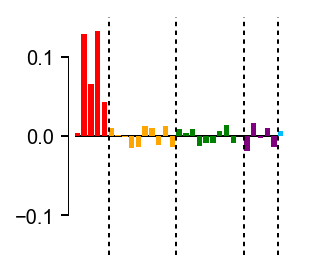

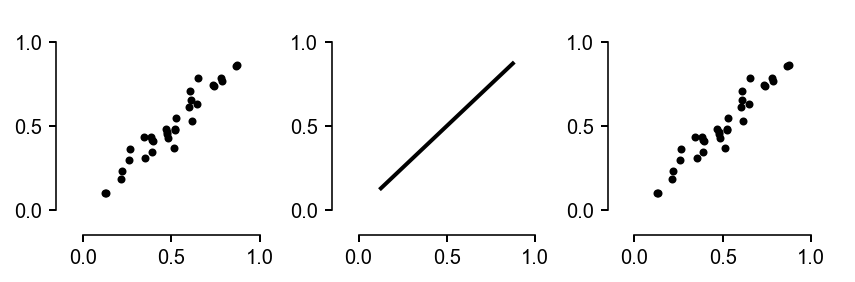

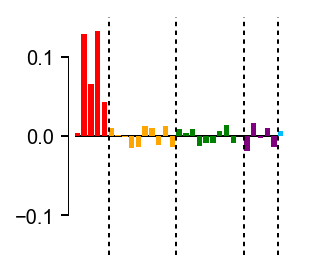

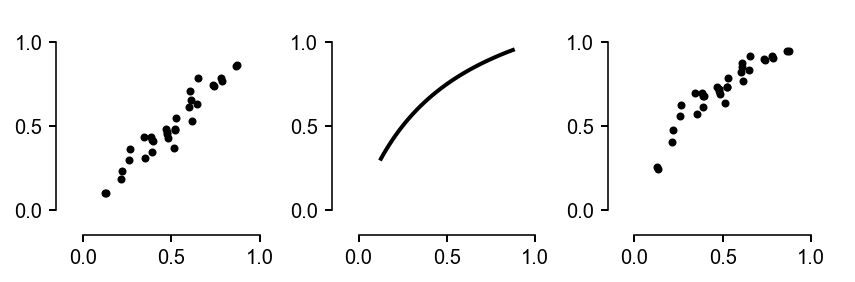

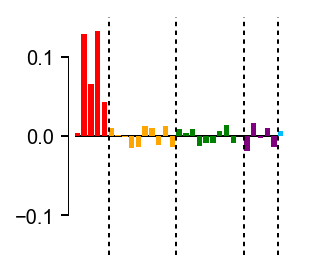

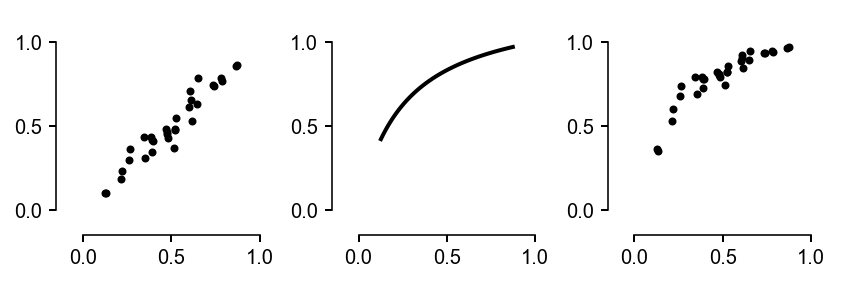

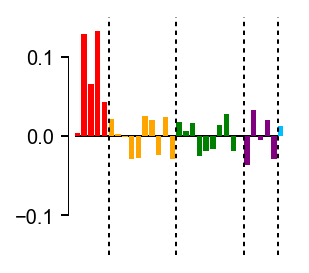

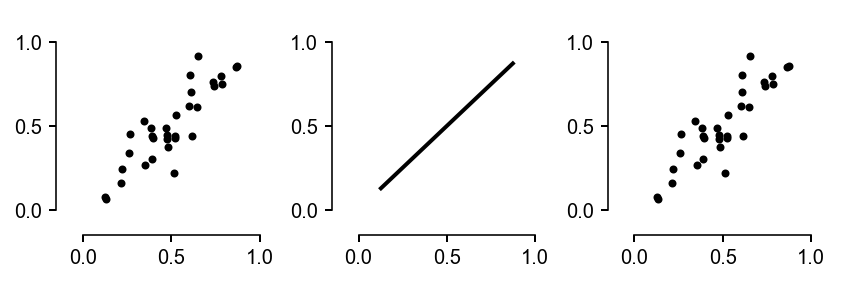

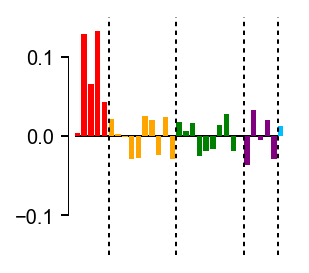

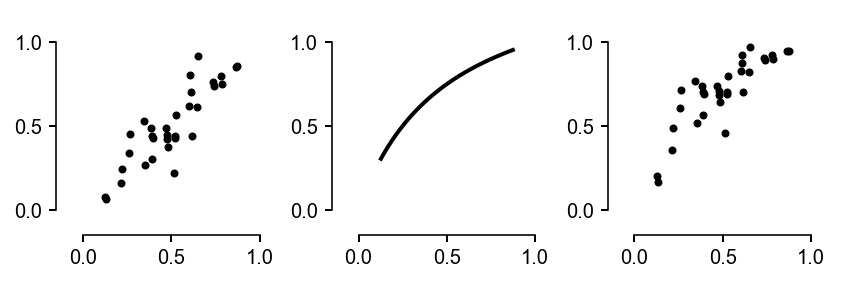

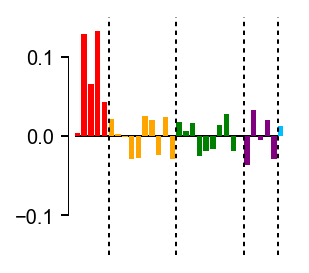

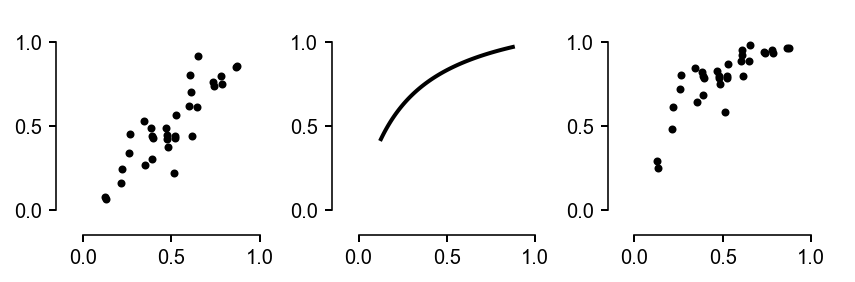

In [143]:
mags = (0.0, 2.0, 4.0)
shapes = (0.0, 2.0, 4.0)

for m in mags:
    for j in shapes:
        
        results = fig3(
            magnitude_of_epistasis=m,
            shape=j,
            order=6,
            show_epistasis=True, 
            save=True)
        model = results[2]
        magnitude_of_epistasis = results[3]
        shape = results[4]
        model.fit()
        
        '''
        fig, ax = plt.subplots(figsize=(2,2))

        padd = model.statistics.linear()
        pobs = model.phenotypes
        ax.plot(padd, pobs, 'k.')
        
        model_x = np.linspace(min(padd), max(padd), 100) 
        model_y = model.function(model_x, *model.parameters.get_params())
        ax.plot(model_x, model_y, 'r-')

        ax.axis("equal")
        ax.axis([-0.1,1.1,-0.1,1.1])

        fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/model" +
                    str(magnitude_of_epistasis) + "-" + str(shape) + ".svg", format="svg")
        '''

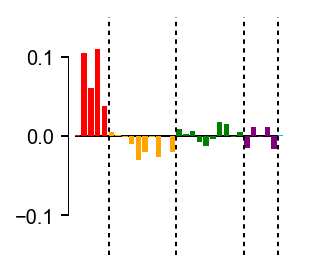

In [127]:
# Fit with linear model.
model_lin = LinearEpistasisModel.from_gpm(nonlinear, model_type="global")
model_lin.fit()
fig, ax = epistasis(model_lin.epistasis.values, model_lin.epistasis.labels, figsize=(2.25,2), y_axis_name="", xgrid=False, ybounds=(-.15,.15))
fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/linear-coeffs.svg", format="svg", bbox_height="tight")

In [120]:
phenotypes_ = reverse_function(model.phenotypes, *model.parameters.get_params())

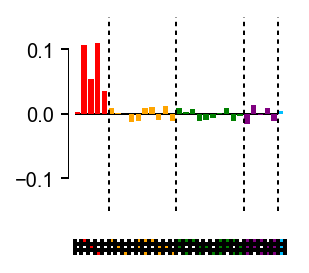

In [129]:
phenotypes_ = reverse_function(model.phenotypes, *model.parameters.get_params())
trans_lin = LinearEpistasisModel.from_gpm(nonlinear, model_type="global")
trans_lin.phenotypes = phenotypes_
trans_lin.fit()

fig, ax = epistasis(trans_lin.epistasis.values, model_lin.epistasis.labels, figsize=(2.25,2), y_axis_name="", xgrid=True, ybounds=(-.15,.15))
fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/tranformed-coeffs2.svg", format="svg", bbox_height="tight")

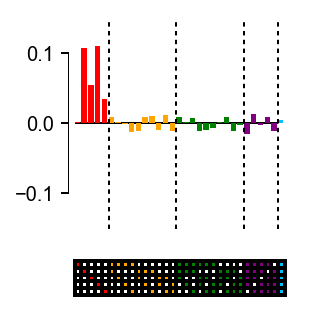

In [142]:
fig, ax = epistasis(trans_lin.epistasis.values, model_lin.epistasis.labels, figsize=(2.25,2.3), height_ratio=5, y_axis_name="", xgrid=True, ybounds=(-.15,.15))
fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/grid-fig.svg", format="svg", bbox_height="tight")

0.934030995152


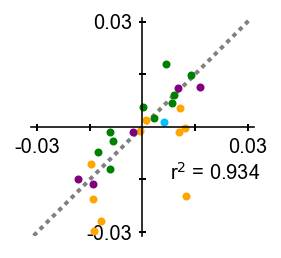

In [130]:
fig, ax = plt.subplots(figsize=(2,2))

model1 = linear
model2 = model_lin

orders = range(2, model1.length+1)
colors = ("red","orange","green","purple","DeepSkyBlue","yellow","pink")

for o in orders:
    mapping1 = model1.epistasis.getorder[o]
    mapping2 = model2.epistasis.getorder[o]
    z1 = mapping1.values
    z2 = mapping2.values
    ax.plot(z1, z2, '.', markersize=6, color=colors[o-1])
    
r2 = pearson(model1.epistasis.values[1:], model2.epistasis.values[1:])**2
print(r2)
ax.annotate(s="r$^{2}$ = " + str(round(r2,3)), xy=(0.008,-0.015))
ax.axis("equal")
ax.axis([-.031, .031, -0.031, 0.031])
#plt.axis("equal")
size = ax.axis()
t = np.linspace(size[0],size[1], 10)
ax.plot(t,t, ":", color="gray", zorder=0)
#ax.hlines(0, -1,1, linewidth=.5)
#ax.vlines(0, -1,1, linewidth=.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_position('center')
ax.spines["left"].set_position('center')
ax.set_xticks([-.03,-.015, .015, .03])
ax.set_yticks([-.03,-.015, .015, .03])
ax.set_xticklabels([-0.03,'','',0.03])
ax.set_yticklabels([-0.03,'','',0.03])
ax.tick_params(direction="inout")
fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/linear-corr.svg", format="svg", bbox_height="tight")

0.997899307074


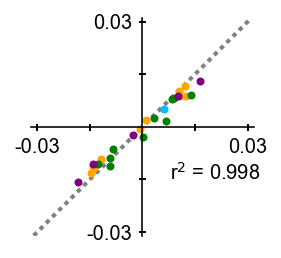

In [123]:
fig, ax = plt.subplots(figsize=(2,2))

model1 = linear
model2 = trans_lin

orders = range(2, model1.length+1)
colors = ("red","orange","green","purple","DeepSkyBlue","yellow","pink")

for o in orders:
    mapping1 = model1.epistasis.getorder[o]
    mapping2 = model2.epistasis.getorder[o]
    z1 = mapping1.values
    z2 = mapping2.values
    ax.plot(z1, z2, '.', markersize=6, color=colors[o-1])
    
r2 = pearson(model1.epistasis.values[1:], model2.epistasis.values[1:])**2
print(r2)
ax.annotate(s="r$^{2}$ = " + str(round(r2,3)), xy=(0.008,-0.015))
ax.axis("equal")
ax.axis([-.031, .031, -0.031, 0.031])
#plt.axis("equal")
size = ax.axis()
t = np.linspace(size[0],size[1], 10)
ax.plot(t,t, ":", color="gray", zorder=0)
#ax.hlines(0, -1,1, linewidth=.5)
#ax.vlines(0, -1,1, linewidth=.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_position('center')
ax.spines["left"].set_position('center')
ax.set_xticks([-.03,-.015, .015, .03])
ax.set_yticks([-.03,-.015, .015, .03])
ax.set_xticklabels([-0.03,'','',0.03])
ax.set_yticklabels([-0.03,'','',0.03])
ax.tick_params(direction="inout")
fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/figures/fig-4/transformed-corr.svg", format="svg", bbox_height="tight")